#**1- Data Loading and Analysis**


Model Training and Evaluation

Hyperparameter Tuning

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
file_path = '/content/drive/My Drive/sentiment140.csv'
column_names = ["target", "id", "date", "flag", "user", "text"]
#adding column names manually since the dataset doesnt have
df = pd.read_csv(file_path,encoding='ISO-8859-1', names=column_names)
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [20]:
nan_counts = df.isna().sum()
print("NaN values in each column:\n", nan_counts)

NaN values in each column:
 target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64


In [21]:
unique_counts = df.nunique()
print("Unique values in each column:\n", unique_counts)

Unique values in each column:
 target          2
id        1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64


In [22]:
#counts for each sentiment (0 = Negative, 4 = Positive)
sentiment_counts = df['target'].value_counts()
print("Sentiment Distribution Counts:\n", sentiment_counts)

Sentiment Distribution Counts:
 target
0    800000
4    800000
Name: count, dtype: int64


# **2- Data Preparation**

In [23]:
#we can drop the columns we dont need
df.drop(['id','date','flag','user'],axis=1,inplace=True)
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [24]:
print("Unique values in 'target' column:", df['target'].unique())

Unique values in 'target' column: [0 4]


In [25]:
#turning 'target' variable into to binary variable since it has only 2 unique values
#0 for negative, 1 for positive
df['target'] = df['target'].apply(lambda x: 0 if x == 0 else 1)
print("Unique values in 'target' after conversion:", df['target'].unique())

Unique values in 'target' after conversion: [0 1]


# **3- Text Preprocessing**

In [26]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [27]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [28]:
import re
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [34]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {
    "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
    "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
    "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "can't": "can not", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
    "mustn't": "must not"
}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def preprocess_text(text):

    # Remove HTML artifacts
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped

    #Remove URL and @ and #
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)

    # Convert to lowercase
    lower = stripped.lower()

    # Handle negations
    negations = neg_pattern.sub(lambda x: negations_dic[x.group()], lower)

    #Remove punctuation and keep only letters
    punct = re.sub("[^a-zA-Z]", " ", negations)

    #Tokenize and remove extra spaces
    words = [x for x in tok.tokenize(punct) if len(x) > 1]

    #Remove stopwords
    #words = [word for word in words if not word in stop_words]

    #Stemming
    porter = PorterStemmer()
    stemmed_tokens = [porter.stem(word) for word in words]

    # #Lemmitizing
    # lemmatizer = WordNetLemmatizer()
    # lemmatized_tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens_without_sw]

    return " ".join(stemmed_tokens)
df['text'] = df['text'].apply(preprocess_text)
df_prep = df.sample(frac=0.5, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-34-a18006e02f1b>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


In [22]:
df_prep

,target,text
541200,0,ahhh hope your ok
750,0,cool have no tweet app for my razr
766711,0,know just famili drama it lame hey next time h...
285055,0,school email will not open and have geographi ...
705995,0,upper airway problem
...,...,...
953018,1,no see them at hampden in glasgow alway treat
993770,1,brr it in san antonio in may
937940,1,know thi sound random veri much fan of your pi...
208691,0,want to leav me for thi dude


In [23]:
sentiment_counts = df_prep['target'].value_counts()
print("Sentiment Distribution Counts After Taking Sample:\n", sentiment_counts)

Sentiment Distribution Counts After Taking Sample:
 target
0    400212
1    399788
Name: count, dtype: int64


In [24]:
#save df_prep as csv file
df_prep.to_csv('/content/drive/My Drive/df_prep.csv', index=False)

In [3]:
import pandas as pd
df_prep = pd.read_csv('/content/drive/My Drive/df_prep.csv')
df_prep

,target,text
0,0,ahhh hope your ok
1,0,cool have no tweet app for my razr
2,0,know just famili drama it lame hey next time h...
3,0,school email will not open and have geographi ...
4,0,upper airway problem
...,...,...
799995,1,no see them at hampden in glasgow alway treat
799996,1,brr it in san antonio in may
799997,1,know thi sound random veri much fan of your pi...
799998,0,want to leav me for thi dude


In [30]:
#save df as csv file
df.to_csv('/content/drive/My Drive/df.csv', index=False)

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/df.csv')
df

# **4- Data Visualization**
Word Cloud

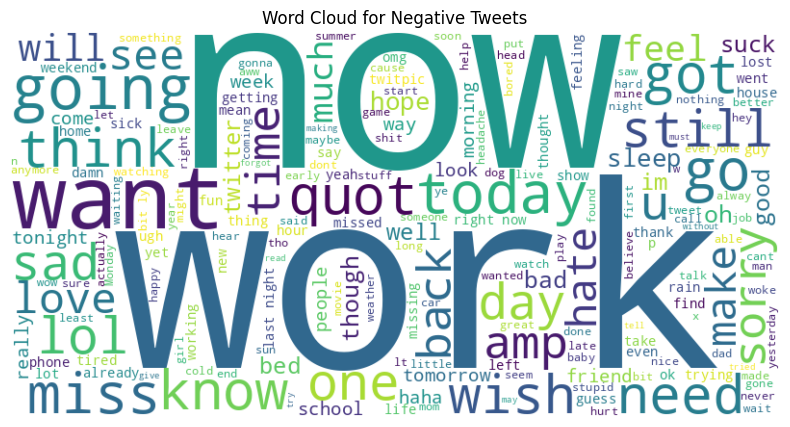

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
negative = df[df['target'] == 0]
negative_strings = []
for i in negative['text']:
    negative_strings.append(i)
negative_strings = pd.Series(negative_strings).str.cat(sep=' ')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_strings)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Tweets')
plt.show()


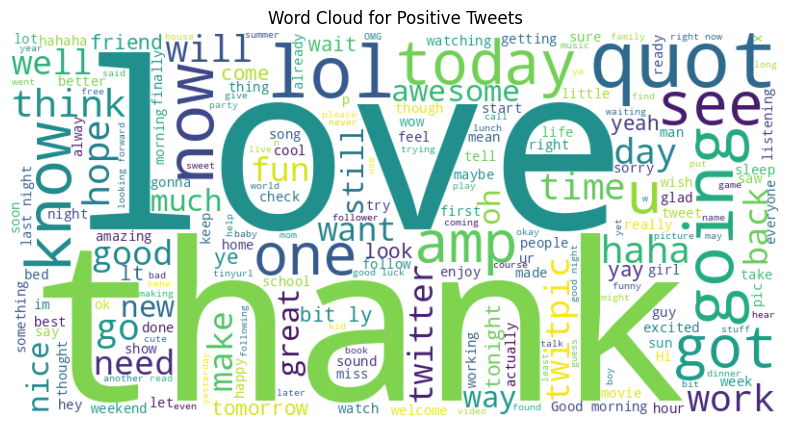

In [27]:
positive = df[df['target'] == 1]
positive_strings = []
for i in positive['text']:
    positive_strings.append(i)
positive_strings = pd.Series(positive_strings).str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_strings)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')
plt.show()

In [4]:
df_prep['text'].isna().sum()

2020

In [5]:
df_prep = df_prep.dropna(subset=['text'])

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
vectorizer = CountVectorizer()
vectorizer.fit(df['text'])
negative_doc_matrix = vectorizer.transform(df[df.target == 0]['text'])
positive_doc_matrix = vectorizer.transform(df[df.target == 1]['text'])
negative_tf = np.sum(negative_doc_matrix, axis=0)
positive_tf = np.sum(positive_doc_matrix, axis=0)
neg = np.squeeze(np.asarray(negative_tf))
pos = np.squeeze(np.asarray(positive_tf))
term_freq_df = pd.DataFrame([neg, pos], columns=vectorizer.get_feature_names_out(), index=['Negative', 'Positive']).T
term_freq_df['Total'] = term_freq_df['Negative'] + term_freq_df['Positive']
term_freq_df = term_freq_df.sort_values(by='Total', ascending=False)
term_freq_df.head(10)


,Negative,Positive,Total
to,313176,252704,565880
the,257869,266003,523872
my,190846,125983,316829
it,157225,147544,304769
and,153968,149635,303603
you,103842,198194,302036
is,128452,109876,238328
in,115445,101115,216560
for,98986,117362,216348
of,92717,91087,183804


In [31]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
term_freq_df = term_freq_df[~term_freq_df.index.isin(stop_words)]
term_freq_df.head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Negative,Positive,Total
good,29207,62121,91328
day,39858,47200,87058
get,45542,36502,82044
like,41048,37519,78567
go,45582,28350,73932
quot,26176,45931,72107
http,24360,47217,71577
today,38115,30095,68210
work,45455,19545,65000
love,16990,47696,64686


# **5- Hyperparameter Testing**

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time
import numpy as np

x = df_prep['text']
y = df_prep['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model accuracy: {accuracy*100:.2f}%")
    print(f"Training and testing time: {train_test_time:.2f} seconds")
    print("-" * 80)
    return accuracy, train_test_time

def feature_accuracy_checker(vectorizer, classifier, n_features, stop_words=None, ngram_range=(1, 1)):
    vectorizer.set_params(max_features=n_features, stop_words=stop_words, ngram_range=ngram_range)
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier),
    ])
    print(f"Validation result for {n_features} features:")
    acc, tt_time = accuracy_summary(pipeline, x_train, y_train, x_test, y_test)
    return acc, tt_time


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time
import numpy as np

x = df_prep['text']
y = df_prep['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model accuracy: {accuracy*100:.2f}%")
    print(f"Training and testing time: {train_test_time:.2f} seconds")
    print("-" * 80)
    return accuracy, train_test_time

def feature_accuracy_checker(vectorizer, classifier, n_features, stop_words=None, ngram_range=(1, 1)):
    vectorizer.set_params(max_features=n_features, stop_words=stop_words, ngram_range=ngram_range)
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier),
    ])
    print(f"Validation result for {n_features} features:")
    acc, tt_time = accuracy_summary(pipeline, x_train, y_train, x_test, y_test)
    return acc, tt_time

cvec = CountVectorizer()
lr = LogisticRegression(max_iter=500)
n_features = 100000

print("RESULTS FOR UNIGRAM WITHOUT STOP WORDS\n")
unigram_wosw_results = feature_accuracy_checker(cvec, lr, n_features, stop_words='english')

print("RESULTS FOR UNIGRAM WITH STOP WORDS\n")
unigram_with_sw_results = feature_accuracy_checker(cvec, lr, n_features, stop_words=None)

print("RESULTS FOR BIGRAM WITH STOP WORDS\n")
bigram_results = feature_accuracy_checker(cvec, lr, n_features, stop_words=None, ngram_range=(1, 2))

print("RESULTS FOR TRIGRAM WITH STOP WORDS\n")
trigram_results = feature_accuracy_checker(cvec, lr, n_features, stop_words=None, ngram_range=(1, 3))


RESULTS FOR UNIGRAM WITHOUT STOP WORDS

Validation result for 100000 features:
Model accuracy: 76.77%
Training and testing time: 47.92 seconds
--------------------------------------------------------------------------------
RESULTS FOR UNIGRAM WITH STOP WORDS

Validation result for 100000 features:
Model accuracy: 79.02%
Training and testing time: 73.65 seconds
--------------------------------------------------------------------------------
RESULTS FOR BIGRAM WITH STOP WORDS

Validation result for 100000 features:
Model accuracy: 80.76%
Training and testing time: 98.31 seconds
--------------------------------------------------------------------------------
RESULTS FOR TRIGRAM WITH STOP WORDS

Validation result for 100000 features:
Model accuracy: 80.95%
Training and testing time: 129.00 seconds
--------------------------------------------------------------------------------


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
lr = LogisticRegression(max_iter=500)
n_features = 100000

print("RESULTS FOR UNIGRAM WITHOUT STOP WORDS (TF-IDF)\n")
unigram_wosw_tfidf_results = feature_accuracy_checker(tfidf_vectorizer, lr, n_features, stop_words='english')

print("RESULTS FOR UNIGRAM WITH STOP WORDS (TF-IDF)\n")
unigram_with_sw_tfidf_results = feature_accuracy_checker(tfidf_vectorizer, lr, n_features, stop_words=None)

print("RESULTS FOR BIGRAM WITH STOP WORDS (TF-IDF)\n")
bigram_tfidf_results = feature_accuracy_checker(tfidf_vectorizer, lr, n_features, stop_words=None, ngram_range=(1, 2))

print("RESULTS FOR TRIGRAM WITH STOP WORDS (TF-IDF)\n")
trigram_tfidf_results = feature_accuracy_checker(tfidf_vectorizer, lr, n_features, stop_words=None, ngram_range=(1, 3))


RESULTS FOR UNIGRAM WITHOUT STOP WORDS (TF-IDF)

Validation result for 100000 features:
Model accuracy: 76.92%
Training and testing time: 17.92 seconds
--------------------------------------------------------------------------------
RESULTS FOR UNIGRAM WITH STOP WORDS (TF-IDF)

Validation result for 100000 features:
Model accuracy: 79.18%
Training and testing time: 24.47 seconds
--------------------------------------------------------------------------------
RESULTS FOR BIGRAM WITH STOP WORDS (TF-IDF)

Validation result for 100000 features:
Model accuracy: 81.67%
Training and testing time: 64.52 seconds
--------------------------------------------------------------------------------
RESULTS FOR TRIGRAM WITH STOP WORDS (TF-IDF)

Validation result for 100000 features:
Model accuracy: 81.80%
Training and testing time: 84.20 seconds
--------------------------------------------------------------------------------


# **6- Model Testing**

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input

def evaluate_logistic_regression(x_train, y_train, x_test, y_test):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(max_iter=500)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return evaluate_results(y_test, y_pred, "Logistic Regression")

def evaluate_linear_svm(x_train, y_train, x_test, y_test):
    from sklearn.svm import LinearSVC
    model = LinearSVC()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return evaluate_results(y_test, y_pred, "Linear SVM")

def evaluate_random_forest(x_train, y_train, x_test, y_test):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return evaluate_results(y_test, y_pred, "Random Forest")

def evaluate_naive_bayes(x_train, y_train, x_test, y_test):
    model = MultinomialNB()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return evaluate_results(y_test, y_pred, "Naive Bayes")

def evaluate_neural_network(x_train, y_train, x_test, y_test, input_dim, epochs=10, batch_size=128):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    y_pred_prob = model.predict(x_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    return evaluate_results(y_test, y_pred, "Neural Network")

def evaluate_results(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))
    print("-"*60)
    return accuracy


## TF-IDF Vectorizer

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 3), stop_words=None)

x_train_vect = tfidf_vectorizer.fit_transform(x_train)
x_test_vect = tfidf_vectorizer.transform(x_test)

print("Testing Logistic Regression with TfidfVectorizer (Trigram, No Stopword Removal)")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Linear SVM with TfidfVectorizer (Trigram, No Stopword Removal)")
linear_svm_accuracy = evaluate_linear_svm(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Naive Bayes with TfidfVectorizer (Trigram, No Stopword Removal)")
naive_bayes_accuracy = evaluate_naive_bayes(x_train_vect, y_train, x_test_vect, y_test)


Testing Logistic Regression with TfidfVectorizer (Trigram, No Stopword Removal)
Model: Logistic Regression
Accuracy: 81.80%
Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.81      0.82     79523
    positive       0.81      0.83      0.82     80073

    accuracy                           0.82    159596
   macro avg       0.82      0.82      0.82    159596
weighted avg       0.82      0.82      0.82    159596

------------------------------------------------------------
Testing Linear SVM with TfidfVectorizer (Trigram, No Stopword Removal)
Model: Linear SVM
Accuracy: 80.90%
Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.80      0.81     79523
    positive       0.80      0.82      0.81     80073

    accuracy                           0.81    159596
   macro avg       0.81      0.81      0.81    159596
weighted avg       0.81      0.81      0.81    159596

-------

## Count Vectorizer

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_features=100000, ngram_range=(1, 3), stop_words=None)

x_train_vect = count_vectorizer.fit_transform(x_train)
x_test_vect = count_vectorizer.transform(x_test)

print("Testing Logistic Regression with CountVectorizer (Trigram, No Stopword Removal)")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Linear SVM with CountVectorizer (Trigram, No Stopword Removal)")
linear_svm_accuracy = evaluate_linear_svm(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Naive Bayes with CountVectorizer (Trigram, No Stopword Removal)")
naive_bayes_accuracy = evaluate_naive_bayes(x_train_vect, y_train, x_test_vect, y_test)


Testing Logistic Regression with CountVectorizer (Trigram, No Stopword Removal)
Model: Logistic Regression
Accuracy: 80.95%
Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.79      0.81     79523
    positive       0.80      0.83      0.81     80073

    accuracy                           0.81    159596
   macro avg       0.81      0.81      0.81    159596
weighted avg       0.81      0.81      0.81    159596

------------------------------------------------------------
Testing Linear SVM with CountVectorizer (Trigram, No Stopword Removal)
Model: Linear SVM
Accuracy: 79.29%
Classification Report:

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79     79523
    positive       0.79      0.81      0.80     80073

    accuracy                           0.79    159596
   macro avg       0.79      0.79      0.79    159596
weighted avg       0.79      0.79      0.79    159596

-------

## Hashing Vectorizer

In [37]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(n_features=100000, ngram_range=(1, 3))

x_train_vect = hashing_vectorizer.fit_transform(x_train)
x_test_vect = hashing_vectorizer.transform(x_test)

print("Testing Logistic Regression with Hashing Vectorizer")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Linear SVM with Hashing Vectorizer")
linear_svm_accuracy = evaluate_linear_svm(x_train_vect, y_train, x_test_vect, y_test)

#Naive Bayes Classifier does not support negative values
# print("Testing Naive Bayes with Hashing Vectorizer")
# naive_bayes_accuracy = evaluate_naive_bayes(x_train_vect, y_train, x_test_vect, y_test)


Testing Logistic Regression with Hashing Vectorizer
Model: Logistic Regression
Accuracy: 80.11%
Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80     79523
    positive       0.80      0.81      0.80     80073

    accuracy                           0.80    159596
   macro avg       0.80      0.80      0.80    159596
weighted avg       0.80      0.80      0.80    159596

------------------------------------------------------------
Testing Linear SVM with Hashing Vectorizer
Model: Linear SVM
Accuracy: 78.25%
Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.78      0.78     79523
    positive       0.78      0.79      0.78     80073

    accuracy                           0.78    159596
   macro avg       0.78      0.78      0.78    159596
weighted avg       0.78      0.78      0.78    159596

------------------------------------------------------------


## Doc2Vec Vectorizer

In [38]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

tagged_data = [TaggedDocument(words=row.split(), tags=[i]) for i, row in enumerate(x_train)]

doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=10)
doc2vec_model.build_vocab(tagged_data)

print("Training Doc2Vec model...")
initial_alpha = doc2vec_model.alpha
for epoch in range(doc2vec_model.epochs):
    print(f"Epoch {epoch + 1}/{doc2vec_model.epochs}")
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=1)
    new_alpha = initial_alpha - (epoch + 1) * 0.002
    doc2vec_model.alpha = max(new_alpha, 0.0001)
    doc2vec_model.min_alpha = doc2vec_model.alpha

x_train_vect = np.array([doc2vec_model.infer_vector(doc.split()) for doc in x_train])
x_test_vect = np.array([doc2vec_model.infer_vector(doc.split()) for doc in x_test])

print("Testing Logistic Regression with Doc2Vec")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Random Forest with Doc2Vec")
random_forest_accuracy = evaluate_random_forest(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Neural Network with Doc2Vec")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train, x_test_vect, y_test, input_dim=x_train_vect.shape[1]
)

Training Doc2Vec model...
Epoch 1/10


Epoch 2/1
Epoch 3/1
Epoch 4/1
Epoch 5/1
Epoch 6/1
Epoch 7/1
Epoch 8/1
Epoch 9/1
Epoch 10/1
Testing Logistic Regression with Doc2Vec
Model: Logistic Regression
Accuracy: 60.03%
Classification Report:

              precision    recall  f1-score   support

    negative       0.60      0.60      0.60     79523
    positive       0.60      0.60      0.60     80073

    accuracy                           0.60    159596
   macro avg       0.60      0.60      0.60    159596
weighted avg       0.60      0.60      0.60    159596

------------------------------------------------------------
Testing Random Forest with Doc2Vec
Model: Random Forest
Accuracy: 58.07%
Classification Report:

              precision    recall  f1-score   support

    negative       0.57      0.62      0.60     79523
    positive       0.59      0.54      0.56     80073

    accuracy                           0.58    159596
   macro avg       0.58      0.58      0.58    159596
weighted avg       0.58      0.58      0.58

NameError: name 'Input' is not defined

In [41]:
print("Testing Neural Network with Doc2Vec")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train, x_test_vect, y_test, input_dim=x_train_vect.shape[1]
)

Testing Neural Network with Doc2Vec
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Model: Neural Network
Accuracy: 78.02%
Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.77      0.78     79523
    positive       0.78      0.79      0.78     80073

    accuracy                           0.78    159596
   macro avg       0.78      0.78      0.78    159596
weighted avg       0.78      0.78      0.78    159596

------------------------------------------------------------


## FastText Vectorizer

In [39]:
from gensim.models import FastText
import numpy as np

fasttext_model = FastText(sentences=[doc.split() for doc in x_train], vector_size=100, window=5, min_count=2, workers=4, epochs=10)

x_train_vect = np.array([np.mean([fasttext_model.wv[word] for word in doc.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for doc in x_train])
x_test_vect = np.array([np.mean([fasttext_model.wv[word] for word in doc.split() if word in fasttext_model.wv] or [np.zeros(100)], axis=0) for doc in x_test])

print("Testing Logistic Regression with FastText")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Random Forest with FastText")
random_forest_accuracy = evaluate_random_forest(x_train_vect, y_train, x_test_vect, y_test)

print("Testing Neural Network with FastText")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train, x_test_vect, y_test, input_dim=x_train_vect.shape[1]
)


Testing Logistic Regression with FastText
Model: Logistic Regression
Accuracy: 75.14%
Classification Report:

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75     79523
    positive       0.75      0.75      0.75     80073

    accuracy                           0.75    159596
   macro avg       0.75      0.75      0.75    159596
weighted avg       0.75      0.75      0.75    159596

------------------------------------------------------------
Testing Random Forest with FastText
Model: Random Forest
Accuracy: 73.96%
Classification Report:

              precision    recall  f1-score   support

    negative       0.73      0.76      0.74     79523
    positive       0.75      0.72      0.74     80073

    accuracy                           0.74    159596
   macro avg       0.74      0.74      0.74    159596
weighted avg       0.74      0.74      0.74    159596

------------------------------------------------------------
Testing Neural N

NameError: name 'Input' is not defined

In [42]:
print("Testing Neural Network with FastText")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train, x_test_vect, y_test, input_dim=x_train_vect.shape[1]
)


Testing Neural Network with FastText
4988/4988 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Model: Neural Network
Accuracy: 78.10%
Classification Report:

              precision    recall  f1-score   support

    negative       0.78      0.77      0.78     79523
    positive       0.78      0.79      0.78     80073

    accuracy                           0.78    159596
   macro avg       0.78      0.78      0.78    159596
weighted avg       0.78      0.78      0.78    159596

------------------------------------------------------------


## Sentence Transformer Vectorizer

In [17]:
from sentence_transformers import SentenceTransformer
import numpy as np

sentence_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

x_train_sample = x_train.sample(frac=0.1, random_state=42)
x_test_sample = x_test.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[x_train_sample.index]
y_test_sample = y_test.loc[x_test_sample.index]

x_train_vect = np.array(sentence_transformer.encode(x_train_sample.tolist(), show_progress_bar=True))
x_test_vect = np.array(sentence_transformer.encode(x_test_sample.tolist(), show_progress_bar=True))

print("Testing Logistic Regression with Sentence Transformer")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train_sample, x_test_vect, y_test_sample)

print("Testing Random Forest with Sentence Transformer")
random_forest_accuracy = evaluate_random_forest(x_train_vect, y_train_sample, x_test_vect, y_test_sample)

print("Testing Neural Network with Sentence Transformer")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train_sample, x_test_vect, y_test_sample, input_dim=x_train_vect.shape[1]
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1995 [00:00<?, ?it/s]

Batches:   0%|          | 0/499 [00:00<?, ?it/s]

Testing Logistic Regression with Sentence Transformer
Model: Logistic Regression
Accuracy: 75.55%
Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.75      0.75      7954
    positive       0.75      0.76      0.76      8006

    accuracy                           0.76     15960
   macro avg       0.76      0.76      0.76     15960
weighted avg       0.76      0.76      0.76     15960

------------------------------------------------------------
Testing Random Forest with Sentence Transformer
Model: Random Forest
Accuracy: 71.80%
Classification Report:

              precision    recall  f1-score   support

    negative       0.71      0.73      0.72      7954
    positive       0.72      0.71      0.72      8006

    accuracy                           0.72     15960
   macro avg       0.72      0.72      0.72     15960
weighted avg       0.72      0.72      0.72     15960

-----------------------------------------------------

## DistilBERT Vectorizer

In [16]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

def distilbert_encode_batch(texts, max_length=64, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors='pt')
        with torch.no_grad():
            batch_embeddings = distilbert_model(**tokens).last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

x_train_sample = x_train.sample(frac=0.1, random_state=42)
x_test_sample = x_test.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[x_train_sample.index]
y_test_sample = y_test.loc[x_test_sample.index]

x_train_vect = distilbert_encode_batch(x_train_sample, max_length=64, batch_size=16)
x_test_vect = distilbert_encode_batch(x_test_sample, max_length=64, batch_size=16)

print("Testing Logistic Regression with DistilBERT")
logistic_accuracy = evaluate_logistic_regression(x_train_vect, y_train_sample, x_test_vect, y_test_sample)

print("Testing Random Forest with DistilBERT")
random_forest_accuracy = evaluate_random_forest(x_train_vect, y_train_sample, x_test_vect, y_test_sample)

print("Testing Neural Network with DistilBERT")
neural_network_accuracy = evaluate_neural_network(
    x_train_vect, y_train_sample, x_test_vect, y_test_sample, input_dim=x_train_vect.shape[1]
)


Testing Logistic Regression with DistilBERT
Model: Logistic Regression
Accuracy: 75.07%
Classification Report:

              precision    recall  f1-score   support

    negative       0.75      0.75      0.75      7954
    positive       0.75      0.76      0.75      8006

    accuracy                           0.75     15960
   macro avg       0.75      0.75      0.75     15960
weighted avg       0.75      0.75      0.75     15960

------------------------------------------------------------
Testing Random Forest with DistilBERT
Model: Random Forest
Accuracy: 70.89%
Classification Report:

              precision    recall  f1-score   support

    negative       0.70      0.73      0.71      7954
    positive       0.72      0.69      0.70      8006

    accuracy                           0.71     15960
   macro avg       0.71      0.71      0.71     15960
weighted avg       0.71      0.71      0.71     15960

------------------------------------------------------------
Testing Neur

# Final Test

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

x = df['text']  #all dataset
y = df['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=100000, ngram_range=(1, 3), stop_words=None)
x_train_vect = tfidf_vectorizer.fit_transform(x_train)
x_test_vect = tfidf_vectorizer.transform(x_test)

logistic_model = LogisticRegression(max_iter=500)
logistic_model.fit(x_train_vect, y_train)

y_pred = logistic_model.predict(x_test_vect)

print("Testing Logistic Regression with TfidfVectorizer (Trigram)")
accuracy = evaluate_logistic_regression(x_train_vect, y_train, x_test_vect, y_test)


Testing Logistic Regression with TfidfVectorizer (Trigram)
Model: Logistic Regression
Accuracy: 82.30%
Classification Report:

              precision    recall  f1-score   support

    negative       0.83      0.81      0.82    159494
    positive       0.82      0.83      0.83    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

------------------------------------------------------------
